# Setup

In [ ]:
%%capture
%pip install git+https://github.com/neelnanda-io/TransformerLens.git
!pip install faker

In [ ]:
import torch
from typing import Optional
import copy

In [ ]:
import transformer_lens.utils as utils  # for test prompts
from transformer_lens import HookedTransformer
torch.set_grad_enabled(False)

## Load Model

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


## Import functions from repo

In [ ]:
!git clone https://github.com/apartresearch/seqcont_circuits.git
%cd /content/seqcont_circuits/src/generate_data

Cloning into 'seqcont_circ_expms'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 339 (delta 213), reused 302 (delta 179), pack-reused 0
Receiving objects: 100% (339/339), 15.01 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (213/213), done.


In [ ]:
from generate_data import *

# numwords, months- names

In [ ]:
from faker import Faker

# Generate 100 unique first names
fake = Faker()
first_names = set()
while len(first_names) < 500:
    first_name = fake.first_name()
    first_names.add(first_name)
first_names = list(first_names)

In [ ]:
names = filter_to_single_token(model, first_names)
len(names)

137

In [ ]:
# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, names[:100], 'born')

In [ ]:
# Replace the month names in the data
prompts_list_months = replace_nw_seqtype(prompts_list, 'months')

In [ ]:
good_prompts, good_prompts_months, all_probs = get_good_prompts_nw_months(model, prompts_list, prompts_list_months)

In [ ]:
print(len(good_prompts))
print(len(good_prompts_months))

In [ ]:
example_prompt = good_prompts[57]['text']
example_answer = good_prompts[57]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

In [ ]:
example_prompt = good_prompts_months[50]['text']
example_answer = good_prompts_months[50]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

In [ ]:
with open('nw_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('nw_prompts_names.pkl')

In [ ]:
with open('months_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts_months, file)
files.download('months_prompts_names.pkl')

In [ ]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

In [ ]:
freqs = {}
for pd in good_prompts_months:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

In [ ]:
freqs = {}
for pd in good_prompts:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

# numwords, months- lost

In [ ]:
# List of common, short words which are likely to be single tokens in GPT-2
common_words = [
    "Apple", "Ball", "Car", "Dog", "Egg", "Fish", "Gold", "Hat", "Ink", "Jar",
    "Kite", "Lamp", "Moon", "Nest", "Owl", "Pig", "Quilt", "Rat", "Sun", "Tree",
    "Umbrella", "Vase", "Wolf", "Yarn", "Zip", "Bird", "Cat", "Drum", "Frog",
    "Grape", "House", "Ice", "Juice", "Key", "Leaf", "Map", "Nut", "Orange",
    "Piano", "Queen", "Ring", "Star", "Train", "Van", "Whale", "Xylophone",
    "Yacht", "Zebra", "Ax", "Box", "Cow", "Desk", "Ear", "Fan", "Gate", "Hill",
    "Iron", "Joke", "King", "Lion", "Milk", "Nose", "Oil", "Pen", "Quiz", "Rose",
    "Shoe", "Tail", "Vine", "Wall", "Year", "Ant", "Bug", "Corn", "Duck", "Fire",
    "Grass", "Hand", "Island", "Jam", "Knee", "Lake", "Mouse", "Nail", "Pear",
    "Quack", "Road", "Sand", "Tent", "Valley", "Wind", "Yard", "Arm", "Boat",
    "Cake", "Door", "Eye", "Flag", "Horse", "Jeep", "Knife", "Light", "Mountain",
    "Night", "Ocean", "Plate", "Queen", "Rain", "Snow", "Tree", "Umbrella",
    "Valley", "Window", "Yogurt", "Zoo", "Balloon", "Bicycle", "Car", "Doll", "Eagle", "Flag", "Giraffe", "Helmet", "Igloo", "Jacket",
    "Kite", "Lion", "Monkey", "Nest", "Oven", "Pencil", "Quill", "Rabbit", "Star", "Truck",
    "Umbrella", "Violin", "Whale", "Xylophone", "Yak", "Zebra", "Apple", "Banana", "Camera", "Drum",
    "Elephant", "Fork", "Glass", "House", "Island", "Jewel", "Kangaroo", "Lamp", "Mountain", "Notebook",
    "Orange", "Piano", "Queen", "Rose", "Snake", "Tiger", "Urn", "Vase", "Window", "Xerox",
    "Yoyo", "Zipper", "Anchor", "Brush", "Clock", "Dress", "Easel", "Fan", "Guitar", "Harp",
    "Ink", "Jug", "Knife", "Leaf", "Mirror", "Nut", "Owl", "Penguin", "Quartz", "Ring",
    "Spoon", "Table", "Ukulele", "Van", "Watch", "X-ray", "Yarn", "Zucchini", "Artichoke", "Broccoli",
    "Cup", "Desk", "Egg", "Fridge", "Grape", "Hose", "Iris", "Jackal", "Kettle", "Lizard",
    "Mango", "Napkin", "Ostrich", "Peacock", "Quokka", "Racoon", "Seal", "Tulip", "Urchin", "Violet",
    "apple", "ball", "chair", "desk", "elephant", "flower", "guitar", "hat", "jug", "kite",
    "lamp", "mirror", "orange", "piano", "quilt", "ring", "television", "umbrella", "violin", "watch",
    "yacht", "zebra", "book", "cup", "drone", "fridge", "gloves", "helmet", "igloo", "jacket",
    "key", "lemon", "mug", "nail", "octopus", "pillow", "robot", "spoon", "tree", "unicorn",
    "vase", "wheel", "yo-yo", "zipper", "backpack", "camera", "dumbbell", "envelope", "flashlight", "goggles",
    "hammer", "ink", "jeans", "ladder", "microphone", "nest", "owl", "penguin", "quill", "ruler",
    "scissors", "tent", "volcano", "wallet", "yogurt", "zucchini", "accordion", "bicycle", "candle", "dice",
    "egg", "fan"
    ]

In [ ]:
random_single_word_objects = [obj.capitalize() for obj in common_words]
random_single_word_objects = filter_to_single_token(model, random_single_word_objects)
len(random_single_word_objects)

100

In [ ]:
prompts_list = generate_prompts_list(0, 8, random_single_word_objects, 'lost')

In [ ]:
prompts_list_months = replace_nw_seqtype(prompts_list, 'months')

In [ ]:
good_prompts, good_prompts_months, all_probs = get_good_prompts_nw_months(model, prompts_list, prompts_list_months)

In [ ]:
with open('nw_prompts_lost.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('nw_prompts_lost.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('months_prompts_lost.pkl', 'wb') as file:
    pickle.dump(good_prompts_months, file)
files.download('months_prompts_lost.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

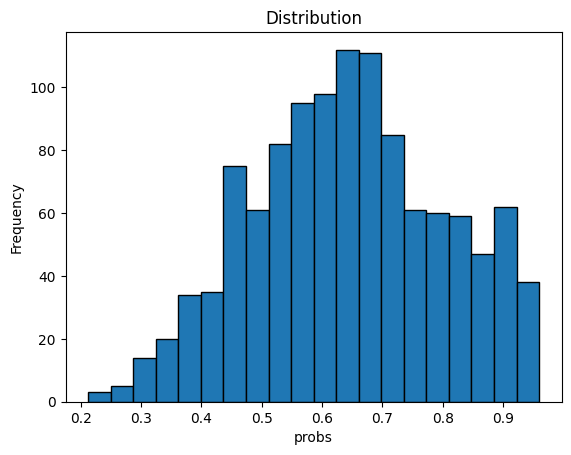

In [ ]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

In [ ]:
freqs = {}
for pd in good_prompts_months:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'January': 128,
 'February': 128,
 'March': 128,
 'April': 128,
 'May': 128,
 'June': 128,
 'July': 128,
 'August': 128}

In [ ]:
freqs = {}
for pd in good_prompts:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'one': 128,
 'two': 128,
 'three': 128,
 'four': 128,
 'five': 128,
 'six': 128,
 'seven': 128,
 'eight': 128}

# numwords, months- done

In [ ]:
prompts_list = generate_prompts_list(0, 8, random_single_word_objects, 'done')

In [ ]:
prompts_list_months = replace_nw_seqtype(prompts_list, 'months')

In [ ]:
good_prompts, good_prompts_months, all_probs = get_good_prompts_nw_months(model, prompts_list, prompts_list_months)

In [ ]:
with open('nw_prompts_done.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('nw_prompts_done.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('months_prompts_done.pkl', 'wb') as file:
    pickle.dump(good_prompts_months, file)
files.download('months_prompts_done.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

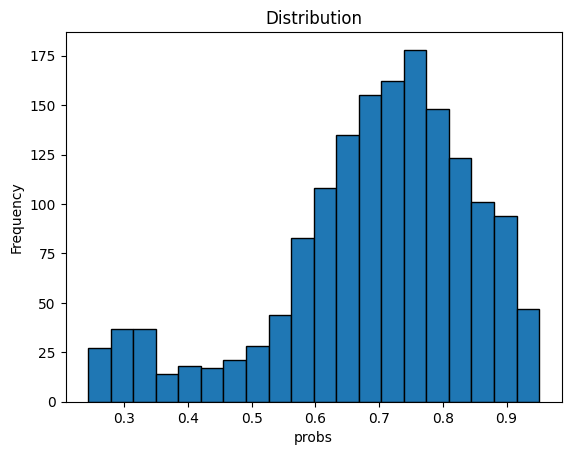

In [ ]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

In [ ]:
freqs = {}
for pd in good_prompts_months:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'January': 128,
 'February': 128,
 'March': 128,
 'April': 128,
 'May': 128,
 'June': 128,
 'July': 128,
 'August': 128}

In [ ]:
freqs = {}
for pd in good_prompts:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'one': 128,
 'two': 128,
 'three': 128,
 'four': 128,
 'five': 128,
 'six': 128,
 'seven': 128,
 'eight': 128}

# numerals- names

In [ ]:
file_name = 'nw_prompts_names.pkl'
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

In [ ]:
prompts_list = replace_nw_seqtype(prompts_list, 'numerals')

In [ ]:
good_prompts, all_probs = get_good_prompts_numerals(model, prompts_list)

In [ ]:
with open('digits_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('digits_prompts_names.pkl')

In [ ]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# numerals- lost

In [ ]:
file_name = 'nw_prompts_lost.pkl'
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Oil lost in one. Apple lost in two. Tree lost in three. Snow lost in four. Apple lost in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Rose lost in two. Tree lost in three. Jam lost in four. Mouse lost in five. Wheel lost in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Wallet lost in three. Jam lost in four. Wall lost in five. Watch lost in six. Train lost in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Car lost in four. Camera lost in five. Ring lost in six. Tree lost in seven. Chair lost in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Ice lost in five. Tree lost in six. Desk lost in seven. Desk lost in eight. Pen lost in'}, {'S1': 'six', 'S2': 's

In [ ]:
prompts_list = replace_nw_seqtype(prompts_list, 'numerals')

In [ ]:
good_prompts, all_probs = get_good_prompts_numerals(model, prompts_list)

In [ ]:
with open('digits_prompts_lost.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('digits_prompts_lost.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

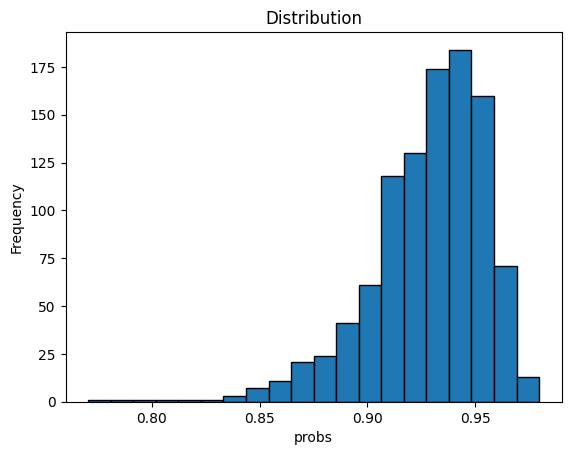

In [ ]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# numerals- done

In [ ]:
file_name = 'nw_prompts_done.pkl'
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Van done in one. Hat done in two. Ring done in three. Desk done in four. Sun done in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Ice done in two. Snow done in three. Watch done in four. Sun done in five. Table done in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Ring done in three. Moon done in four. Queen done in five. Book done in six. Rose done in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Queen done in four. Oil done in five. Rose done in six. Desk done in seven. Car done in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Light done in five. Arm done in six. Road done in seven. Book done in eight. Ice done in'}, {'S1': 'six', 'S2': 'seven', 'S

In [ ]:
prompts_list = replace_nw_seqtype(prompts_list, 'numerals')

In [ ]:
good_prompts, all_probs = get_good_prompts_numerals(model, prompts_list)

In [ ]:
with open('digits_prompts_done.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)
files.download('digits_prompts_done.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

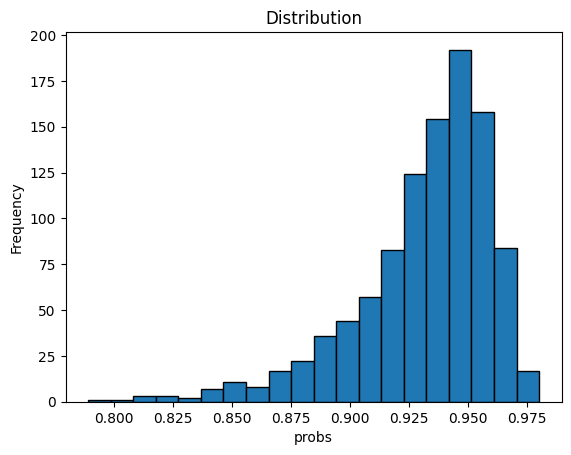

In [ ]:
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')